In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook as tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torch.hub import download_url_to_file
from PIL import Image

import zipfile
from pathlib import Path

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

Let's download the dataset, from figshare.

In [ ]:
if not Path("train_masks.zip").exists():
    download_url_to_file("https://figshare.com/ndownloader/articles/19961426/versions/1", dst="train_masks.zip")
if not Path("train_images.zip").exists():
    download_url_to_file("https://figshare.com/ndownloader/articles/19961336/versions/1", dst="train_images.zip")

100%|██████████| 30.6M/30.6M [00:21<00:00, 1.46MB/s]
100%|██████████| 1.15G/1.15G [01:16<00:00, 16.1MB/s]


In [ ]:
"""Full U-Net module.

Taken from https://github.com/milesial/Pytorch-UNet which
is under GNU-GPL license.
"""

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        factor = 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(
                in_channels, mid_channels, kernel_size=3, padding=1, bias=False
            ),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                mid_channels,
                out_channels,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels, in_channels // 2, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(
            x1,
            [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2],
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## Losses

Let's define several custom losses for semantic segmentation. Note the use of the PyTorch framework and what you should do to implement your own.

In [ ]:
class SemanticCrossEntropyLoss(torch.nn.Module):
    def __init__(self, weight=None):
        """
        Parameters
        ==========
            weight: Optional[Tensor] - a manual rescaling weight given to each class. If given, has to be a Tensor of size C
        """
        super().__init__()
        self.weight = weight

    def forward(self, preds, labels):
        """
        Parameters
        ==========
            preds: Tensor - size (b, C, H, W)
            labels: Tensor - size (b, H, W)
        Returns
        =======
            ce_loss: Tensor - size () the cross entropy loss
        """
        n_classes = preds.size(1)
        preds = preds.permute(0, 2, 3, 1).reshape(-1, n_classes)
        labels = labels.flatten()
        return torch.nn.functional.cross_entropy(preds, labels, weight=self.weight)


class SemanticFocalLoss(torch.nn.Module):
    """
    Focal loss implementation from:

    - Lin, Tsung-Yi, et al. "Focal loss for dense object detection."
      Proceedings of the IEEE international conference on computer vision. 2017.
    """
    def __init__(self, gamma=0.0, weight=None):
        """
        Parameters
        ==========
            gamma : float - the regularization parameter, gamma = 0. will return the value as the SemanticCrossEntropyLoss.
            weight: Optional[Tensor] - a manual rescaling weight given to each class. If given, has to be a Tensor of size C
        """
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, preds, labels):
        """
        Parameters
        ==========
            preds: Tensor - size (b, C, H, W)
            labels: Tensor - size (b, H, W)
        Returns
        =======
            f_loss: Tensor - size () the focal loss
        """
        n_classes = preds.size(1)
        preds = preds.permute(0, 2, 3, 1).reshape(-1, n_classes)
        labels = labels.flatten()
        probs = torch.nn.functional.softmax(preds, dim=-1)
        weighted_probs = (1 - probs) ** self.gamma * probs.log()
        return torch.nn.functional.nll_loss(weighted_probs, labels, weight=self.weight)

## Dataset definition

We extract the downloaded zipfiles and write a `Dataset` subclass to access it.

In [ ]:
train_images_dir = Path("train_images")
if not train_images_dir.exists():
    train_images_zip = zipfile.ZipFile("train_images.zip", "r")
    train_images_dir.mkdir(exist_ok=True)
    train_images_zip.extractall(path=train_images_dir)

In [ ]:
train_masks_dir = Path("train_masks")
if not train_masks_dir.exists():
    train_masks_zip = zipfile.ZipFile("train_masks.zip", "r")
    train_masks_dir.mkdir(exist_ok=True)
    train_masks_zip.extractall(path=train_masks_dir)

In [ ]:
class SemanticSegmentationSatelliteImageryDataset(torch.utils.data.Dataset):
    def __init__(
        self, root, train=True, transform=lambda x: x, mask_transform=lambda x: x
    ):
        super().__init__()
        self.transform = transform
        self.mask_transform = mask_transform
        self.root = Path(root)
        self.train_images = self.root / "train_images"
        self.train_images_files = sorted(list(self.train_images.iterdir()))

        self.train_masks = self.root / "train_masks"
        self.train_masks_files = sorted(list(self.train_masks.iterdir()))

        self.train = train

        # Images ending with a filename ending with either 8 or 9
        # are part of the validation set.
        if train:
            self.train_images_files = [
                f
                for f in self.train_images_files
                if int(f.with_suffix("").name[-1]) < 8
            ]
            self.train_masks_files = [
                f for f in self.train_masks_files if int(f.with_suffix("").name[-1]) < 8
            ]
        else:
            self.train_images_files = [
                f
                for f in self.train_images_files
                if int(f.with_suffix("").name[-1]) >= 8
            ]
            self.train_masks_files = [
                f
                for f in self.train_masks_files
                if int(f.with_suffix("").name[-1]) >= 8
            ]

        self.classes = [
            "Background",
            "Property Roof",
            "Secondary Structure",
            "Swimming Pool",
            "Vehicle",
            "Grass",
            "Trees / Shrubs",
            "Solar Panels",
            "Chimney",
            "Street Light",
            "Window",
            "Satellite Antenna",
            "Garbage Bins",
            "Trampoline",
            "Road/Highway",
            "Under Construction / In Progress Status",
            "Power Lines & Cables",
            "Water Tank / Oil Tank",
            "Parking Area - Commercial",
            "Sports Complex / Arena",
            "Industrial Site",
            "Dense Vegetation / Forest",
            "Water Body",
            "Flooded",
            "Boat",
        ]

        assert len(self.train_images_files) == len(self.train_masks_files)

    def __len__(self):
        return len(self.train_images_files)

    def __getitem__(self, idx):
        mask = Image.open(self.train_masks_files[idx])
        image = Image.open(self.train_images_files[idx]).convert("RGB")
        return self.transform(image), self.mask_transform(mask)

In [ ]:
train_dataset = SemanticSegmentationSatelliteImageryDataset("./", train=True)
val_dataset = SemanticSegmentationSatelliteImageryDataset("./", train=False)
len(train_dataset), len(val_dataset)

(214, 47)

In [ ]:
def view_sample(ds, idx):
    _, axs = plt.subplots(ncols=2)

    img, mask = ds[idx]

    axs[0].imshow(img)
    axs[0].axis("off")

    axs[1].imshow(mask)
    axs[1].axis("off")

    plt.show()

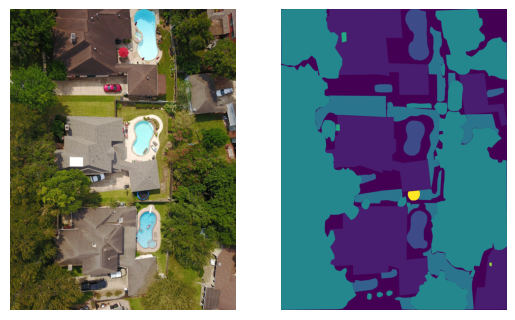

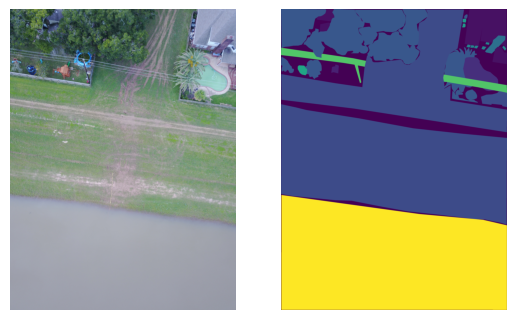

In [ ]:
view_sample(train_dataset, 1)
view_sample(val_dataset, 1)

In [ ]:
import torch
print(torch.cuda.is_available())  # Should print True


True


In [ ]:
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

N_CHANNELS = 3
N_CLASSES = 25

N_EPOCHS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6

NORMALIZATION_MEANS = [0.4643, 0.3185, 0.3141]
NORMALIZATION_STDS = [0.2171, 0.1561, 0.1496]

In [ ]:
model = UNet(n_channels=N_CHANNELS, n_classes=N_CLASSES).to(DEVICE)

In [ ]:
transform = T.Compose(
    [
        T.CenterCrop(3000),
        T.Resize(512),
        T.ToTensor(),
        T.Normalize(mean=NORMALIZATION_MEANS, std=NORMALIZATION_STDS),
    ]
)

mask_transform = T.Compose(
    [
        T.CenterCrop(3000),
        T.Resize(512),
        np.asarray,
        torch.tensor,
    ]
)

train_dataset = SemanticSegmentationSatelliteImageryDataset(
    "./", train=True, transform=transform, mask_transform=mask_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True
)
validation_dataset = SemanticSegmentationSatelliteImageryDataset(
    "./", train=False, transform=transform, mask_transform=mask_transform
)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True
)

In [ ]:
# Try other optimizers if you want !
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Here choose the loss function.
loss_fn = SemanticCrossEntropyLoss()
# loss_fn = SemanticFocalLoss(gamma=1)

losses = []
accs = []

for epoch in range(N_EPOCHS):

    epoch_losses = []

    model.train() # Setting the model in train mode i.e. activates all training layers.

    # Just to have a nice loading bar.
    pbar = tqdm(train_loader, desc=f"Epoch {epoch} ")

    for images, labels in pbar:
        # Remember to send the data to the GPU (if you are using it !).
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        masks_pred = model(images)
        loss = loss_fn(masks_pred, labels) # There was dice loss.

        # You know the drill.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_value = loss.cpu().item()

        epoch_losses.append(loss_value)
        pbar.set_description(f"Epoch {epoch}, Loss : {loss_value:.2f} ")

    losses.append(epoch_losses)

    model.eval()

    # Validations step.

    well_predicted = 0
    total_predicted = 0

    for images, labels in validation_loader:
        with torch.no_grad():
            preds = model(images.to(DEVICE))

        pred_labels = preds.argmax(dim=1)
        well_predicted += (labels.to(DEVICE) == pred_labels).sum()
        total_predicted += labels.numel()

    val_acc = well_predicted / total_predicted
    print(f"Validation Accuracy : {val_acc:2.3f}.")
    accs.append(val_acc)

    torch.save(model.state_dict(), f"semantic_segmentation_si_unet_epoch_{epoch:03d}.model")

Epoch 0 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.556.


Epoch 1 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.557.


Epoch 2 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.581.


Epoch 3 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.581.


Epoch 4 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.567.


Epoch 5 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.599.


Epoch 6 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.579.


Epoch 7 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.614.


Epoch 8 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.607.


Epoch 9 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.614.


Epoch 10 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.626.


Epoch 11 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.617.


Epoch 12 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.618.


Epoch 13 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.614.


Epoch 14 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.633.


Epoch 15 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.634.


Epoch 16 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.630.


Epoch 17 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.652.


Epoch 18 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.596.


Epoch 19 :   0%|          | 0/54 [00:00<?, ?it/s]

Validation Accuracy : 0.647.


:You don't know what is the focal loss ? [Here](https://arxiv.org/abs/1708.02002) is the paper !

In [ ]:
# Here you can save the model for further use.
save_path = "semantic_segmentation_si_unet.model"
torch.save(model.state_dict(), save_path)

[Here](https://www.dropbox.com/s/sllbj3zq3gmwuyx/vaihingen_unet_ce.model?dl=0) you can find an already trained model using the Semantic Cross Entropy ! And [here](https://www.dropbox.com/s/2wgnunp1ps88ab6/vaihingen_unet_focal_loss.model?dl=0) a model trained using the focal loss !

## Let's see the results !

In [ ]:
# Take a validation batch !

images, label4s = next(iter(validation_loader))

model.eval()
with torch.no_grad():
    preds = model(images.to(DEVICE)).cpu()
    pred_labels = preds.argmax(1).squeeze()

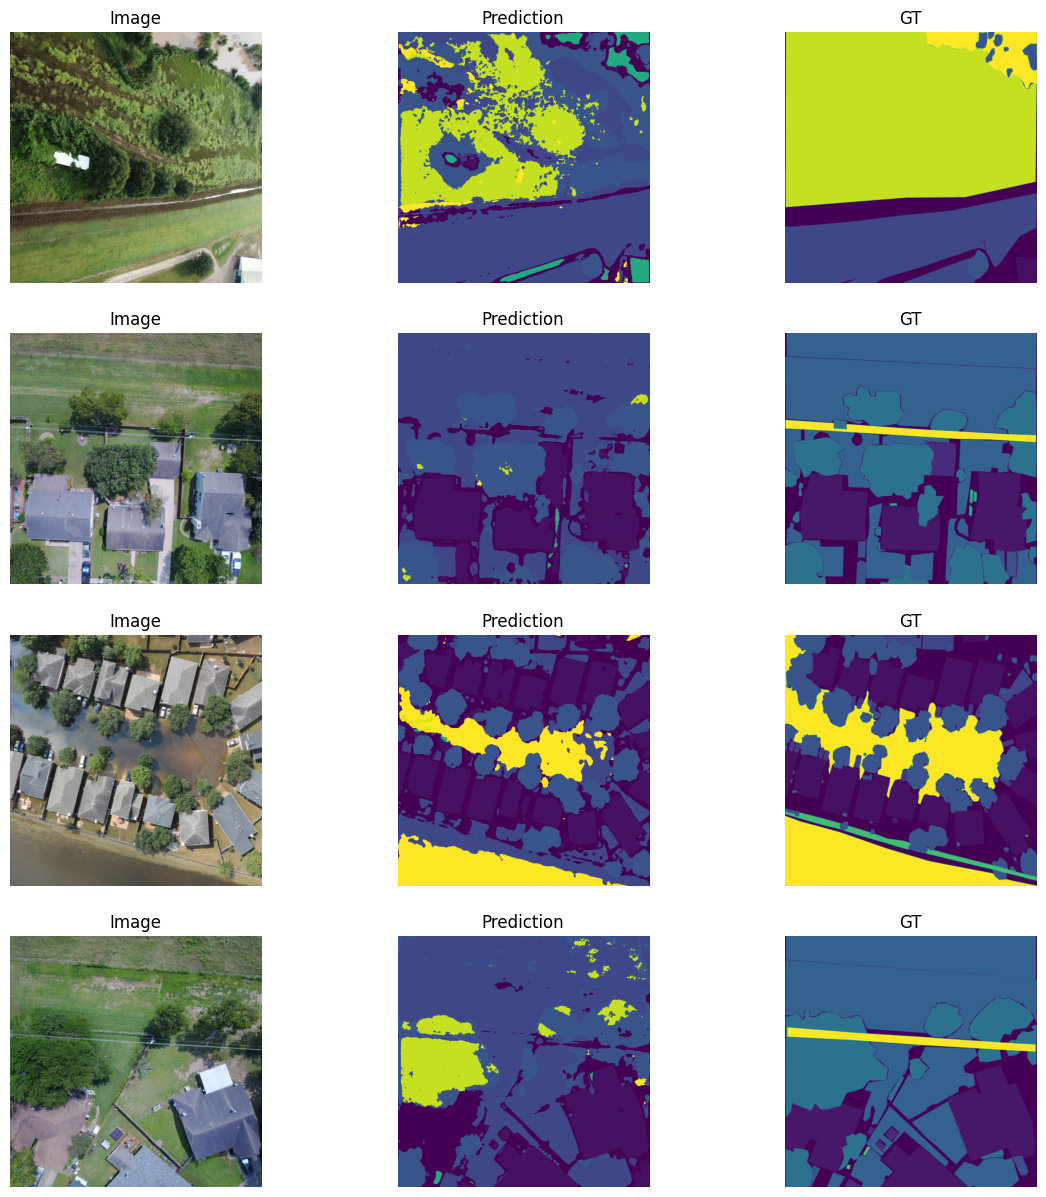

In [ ]:
# And now let's see it !

def denormalize_image(image, mean, std):
    """Denormalize the image."""
    return image * torch.tensor(std)[:, None, None] + torch.tensor(mean)[:, None, None]

fig, axes = plt.subplots(len(images), 3, figsize=(15, 15))
fig.subplots_adjust(wspace=0)

for i, (image, pred_label, gt_label) in enumerate(zip(images, pred_labels, labels)):
    axes[i][0].imshow(denormalize_image(image, NORMALIZATION_MEANS, NORMALIZATION_STDS).permute(1,2,0))
    axes[i][0].axis('off')
    axes[i][0].set_title("Image")
    axes[i][1].imshow(pred_label)
    axes[i][1].axis('off')
    axes[i][1].set_title("Prediction")
    axes[i][2].imshow(gt_label)
    axes[i][2].axis('off')
    axes[i][2].set_title("GT")

plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>